# 把movie文件夹下的imdb_processed.csv读取，分为训练集和测试集，训练集和测试集的特征，都单独写入一个文件，通过subword-nmt命令进行bpe分词

In [38]:
! pip install pandas

In [39]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split

# 读取数据
df = pd.read_csv('movie/imdb_processed.csv')

# 分割训练集和测试集
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# 创建目录（如果不存在）
os.makedirs('movie/bpe', exist_ok=True)

# 将训练集和测试集的文本写入文件
train_df['processed'].to_csv('movie/bpe/train.txt', index=False, header=False)
test_df['processed'].to_csv('movie/bpe/test.txt', index=False, header=False)
# 将训练集和测试集完整数据写入文件
train_df.to_csv('movie/bpe/train_full.csv', index=False)
test_df.to_csv('movie/bpe/test_full.csv', index=False)

print(f"训练集已保存至 'movie/bpe/train_full.csv'，共 {len(train_df)} 条数据")
print(f"测试集已保存至 'movie/bpe/test_full.csv'，共 {len(test_df)} 条数据")


训练集已保存至 'movie/bpe/train_full.csv'，共 40000 条数据
测试集已保存至 'movie/bpe/test_full.csv'，共 10000 条数据


In [40]:
!pwd

/content


In [41]:


# 使用subword-nmt进行BPE分词
# 1. 学习BPE编码（在训练集上）
# 学习bpe分词(很慢,学一次就好)
# -i 选择学习的文件
# -o 核心输出文件,分词需要用到imdb_bpe_code,生成的 imdb_bpe_code 文件包含了学习到的 BPE 操作规则。这些规则用于将单词分割成子词单元
# --write-vocabulary 字典输出文件，imdb_bpe_vocab 文件包含了根据 BPE 规则生成的词汇表，列出了所有子词单元及其频率
# -s 词表大小
!subword-nmt learn-joint-bpe-and-vocab -i ./movie/bpe/train.txt -o ./movie/bpe/imdb_bpe_code --write-vocabulary ./movie/bpe/imdb_bpe_vocab -s 8000

/bin/bash: line 1: subword-nmt: command not found


In [42]:
# 2. 应用BPE编码到训练集和测试集
!subword-nmt apply-bpe -c movie/bpe/imdb_bpe_code -i movie/bpe/train.txt -o movie/bpe/train.bpe.txt
!subword-nmt apply-bpe -c movie/bpe/imdb_bpe_code -i movie/bpe/test.txt -o movie/bpe/test.bpe.txt


/bin/bash: line 1: subword-nmt: command not found
/bin/bash: line 1: subword-nmt: command not found


In [43]:
# # 3. 获取词汇表
# !subword-nmt get-vocab < movie/bpe/imdb_bpe_vocab > movie/bpe/vocab.txt

# print("BPE处理完成！")
# print(f"训练集大小: {len(train_df)}")
# print(f"测试集大小: {len(test_df)}")


In [44]:
# 读取BPE词汇表并构建词典
vocab = {}
special_tokens = {
    "[PAD]": 0,  # 填充 token
    "[BOS]": 1,  # begin of sentence
    "[UNK]": 2,  # 未知 token
    "[EOS]": 3,  # end of sentence
}

# 首先添加特殊标记
vocab.update(special_tokens)

# 读取BPE词汇表
j=len(special_tokens)
with open('movie/bpe/imdb_bpe_vocab', 'r', encoding='utf-8') as f:
    for i, line in enumerate(f):
        token, count = line.strip().split(' ')
        if token not in vocab:  # 避免与特殊标记冲突
            vocab[token] = j
            j+=1

print(f"词典大小: {len(vocab)}")
print(f"前10个词条: {list(vocab.items())[:10]}")


词典大小: 8105
前10个词条: [('[PAD]', 0), ('[BOS]', 1), ('[UNK]', 2), ('[EOS]', 3), ('.', 4), (',', 5), ('I', 6), ('-', 7), ('movie', 8), ('film', 9)]


In [45]:
!wc -l movie/bpe/imdb_bpe_vocab

8101 movie/bpe/imdb_bpe_vocab


# Dataset

# Tokenizer

In [46]:
import torch


class Tokenizer:
    def __init__(self, vocab):
        """
        初始化分词器

        参数:
            vocab: 词汇表字典，将token映射到ID
        """
        self.vocab = vocab #子词到id的映射
        self.id_to_token = {v: k for k, v in vocab.items()} #id到子词的映射
        self.pad_id = vocab["[PAD]"] #填充token的id
        self.bos_id = vocab["[BOS]"]
        self.eos_id = vocab["[EOS]"]
        self.unk_id = vocab["[UNK]"]

    def encode(self, text_list, max_length=None, padding_first=False):
        """
        将文本编码为ID序列

        参数:
            text_list: 输入文本列表，可以是单个句子或多个句子
            max_length: 最大序列长度，如果指定则会进行截断或填充
            padding_first: 如果为True，则在序列前面填充，否则在后面填充

        返回:
            token_ids: ID序列张量
        """

        batch_max_length = 2 + max([len(text) for text in text_list]) # 计算当前批次最大序列长度
        if batch_max_length <max_length:
            max_length = batch_max_length

        indices_list = []
        for text in text_list:
            # 转换为ID
            indices = [self.bos_id] + [self.vocab.get(token, self.unk_id) for token in text[:max_length-2]] + [self.eos_id]

            # 处理填充
            if padding_first:  # padding加在前面
                indices = [self.pad_id] * (max_length - len(indices)) + indices
            else:  # padding加在后面
                indices = indices + [self.pad_id] * (max_length - len(indices))

            indices_list.append(indices)

        return torch.tensor(indices_list)

    def decode(self, token_ids):
        """
        将ID序列解码为文本

        参数:
            token_ids: ID序列

        返回:
            text: 解码后的文本
        """
        if isinstance(token_ids, torch.Tensor):
            token_ids = token_ids.tolist()

        if isinstance(token_ids[0], list):
            return [self.decode(ids) for ids in token_ids]

        tokens = []
        for id in token_ids:
            if id in [self.pad_id, self.bos_id, self.eos_id]:
                continue

            token = self.id_to_token.get(id, "[UNK]")
            tokens.append(token)

        # 合并子词
        text = ""
        for token in tokens:
            if token.endswith("@@"):
                text += token[:-2]  # 移除@@后缀
            else:
                text += token + " "

        return text.strip()


# Dataset

In [47]:
!pwd

/content


In [50]:
import torch
from torch.utils.data import Dataset
import pandas as pd

class IMDBDataset(Dataset):
    """
    IMDB数据集类，用于加载和处理IMDB电影评论数据
    """
    def __init__(self, bpe_file, vocab, max_length=512, mode='train'):
        """
        初始化数据集

        参数:
            bpe_file: 包含BPE处理后的文本文件路径
            csv_file: 包含电影评论标签的CSV文件路径
            vocab: 词汇表字典
            max_length: 序列最大长度
        """
        # 读取标签数据
        # 只读取前4万行数据
        # 根据文件类型决定读取的数据行
        if mode == 'train':
            # 训练集读取前4万行
            self.labels = pd.read_csv('movie/bpe/train_full.csv')['label'].values
        else:
            # 测试集读取最后1万行
            df = pd.read_csv('movie/bpe/test_full.csv')
            self.labels = df.loc[:,'label'].values

        # 读取BPE处理后的文本
        self.texts = []
        with open(bpe_file, 'r', encoding='utf-8') as f:
            self.texts = [line.strip() for line in f]

        # 确保文本和标签数量一致
        assert len(self.texts) == len(self.labels), "文本和标签数量不匹配"

        self.tokenizer = Tokenizer(vocab)
        self.max_length = max_length

    def __len__(self):
        """返回数据集大小"""
        return len(self.texts)

    def __getitem__(self, idx):
        """
        获取指定索引的样本

        参数:
            idx: 样本索引

        返回:
            tokens: 分词后的评论文本
            label: 情感标签 (0表示负面, 1表示正面)
        """
        # 获取评论文本和标签
        text = self.texts[idx]
        label = self.labels[idx]

        return text.split(), label

train_ds = IMDBDataset(bpe_file='movie/bpe/train.bpe.txt',  vocab=vocab, mode='train')
test_ds = IMDBDataset(bpe_file='movie/bpe/test.bpe.txt', vocab=vocab, mode='test')

# print(train_ds[0])
# print(test_ds[0])

/tmp/ipython-input-51-1149141991.py:19: UserWarning: Glyph 24179 (\N{CJK UNIFIED IDEOGRAPH-5E73}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-51-1149141991.py:19: UserWarning: Glyph 22343 (\N{CJK UNIFIED IDEOGRAPH-5747}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-51-1149141991.py:19: UserWarning: Glyph 38271 (\N{CJK UNIFIED IDEOGRAPH-957F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-51-1149141991.py:19: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-51-1149141991.py:19: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-51-1149141991.py:19: UserWarning: Glyph 20301 (\N{CJK UNIFIED IDEOGRAPH-4F4D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-51-1149141991.py:19: UserWarning: Glyph 25968 (\N{CJK UNIFIED I

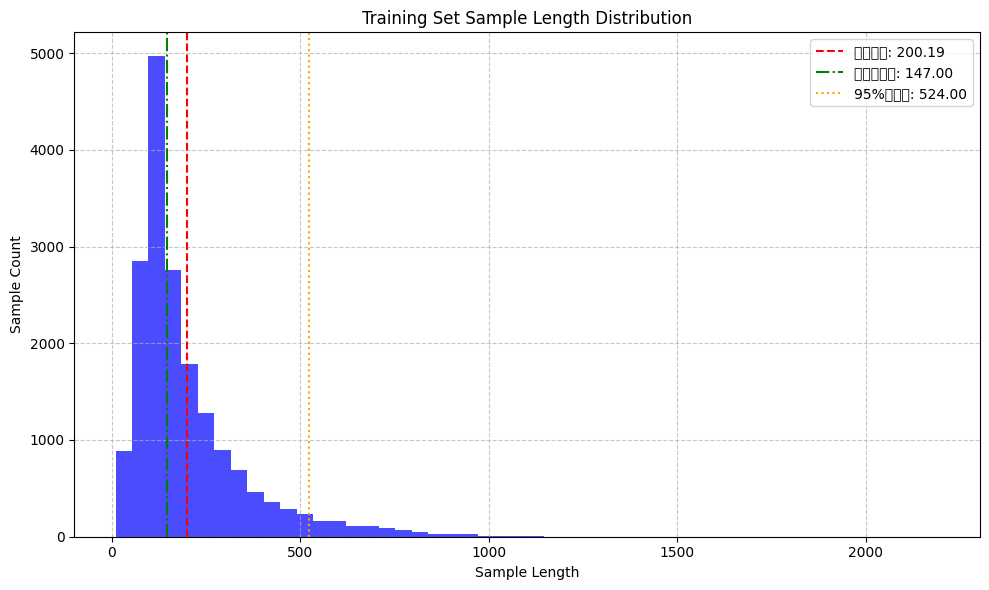

最短样本长度: 10
最长样本长度: 2194
平均样本长度: 200.19
样本长度中位数: 147.0
样本长度标准差: 155.25


In [51]:
import matplotlib.pyplot as plt
# 统计训练集中样本的长度分布
sample_lengths = [len(train_ds[i][0]) for i in range(len(train_ds))]

# 绘制直方图
plt.figure(figsize=(10, 6))
plt.hist(sample_lengths, bins=50, alpha=0.7, color='blue')
plt.xlabel('Sample Length')
plt.ylabel('Sample Count')
plt.title('Training Set Sample Length Distribution')
plt.grid(True, linestyle='--', alpha=0.7)

# 添加一些统计信息
plt.axvline(x=np.mean(sample_lengths), color='r', linestyle='--', label=f'平均长度: {np.mean(sample_lengths):.2f}')
plt.axvline(x=np.median(sample_lengths), color='g', linestyle='-.', label=f'中位数长度: {np.median(sample_lengths):.2f}')
plt.axvline(x=np.percentile(sample_lengths, 95), color='orange', linestyle=':', label=f'95%分位数: {np.percentile(sample_lengths, 95):.2f}')

plt.legend()
plt.tight_layout()
plt.show()

# 打印一些统计信息
print(f"最短样本长度: {min(sample_lengths)}")
print(f"最长样本长度: {max(sample_lengths)}")
print(f"平均样本长度: {np.mean(sample_lengths):.2f}")
print(f"样本长度中位数: {np.median(sample_lengths)}")
print(f"样本长度标准差: {np.std(sample_lengths):.2f}")


# DataLoader

In [52]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

tokenizer = Tokenizer(vocab)

def collate_fct(batch):
    """
    把字符串列表转化为tensor
    :param batch:
    :return:
    """
    text_list = [item[0] for item in batch] #batch中每个item的第一个元素是text,是输入，类型为list
    label_list = [item[1] for item in batch] #batch中每个item的第二个元素是label,是输出，类型为int
    # 这里使用 padding first
    text_list = tokenizer.encode(text_list, max_length=500, padding_first=True).to(dtype=torch.int)
    return text_list, torch.tensor(label_list).reshape(-1, 1).to(dtype=torch.float)

def create_dataloaders(train_ds,test_ds,batch_size=4):
    """
    创建训练集和验证集的DataLoader

    参数:
        train_texts: 训练集文本
        train_labels: 训练集标签
        val_texts: 验证集文本
        val_labels: 验证集标签
        tokenizer: 分词器
        batch_size: 批次大小

    返回:
        train_dataloader: 训练集DataLoader
        val_dataloader: 验证集DataLoader
    """

    # 创建DataLoader
    train_dataloader = DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=collate_fct
    )

    val_dataloader = DataLoader(
        test_ds,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=collate_fct
    )

    return train_dataloader, val_dataloader

# 调用create_dataloaders函数初始化训练集和测试集的DataLoader
batch_size = 32 # 设置批次大小
train_dataloader, val_dataloader = create_dataloaders(
    train_ds=train_ds,
    test_ds=test_ds,
    batch_size=batch_size
)

print(f"训练集DataLoader批次数量: {len(train_dataloader)}")
print(f"验证集DataLoader批次数量: {len(val_dataloader)}")

# 查看一个批次的数据样例
sample_batch = next(iter(train_dataloader))
token_ids, labels = sample_batch
print(f"批次中的token_ids形状: {token_ids.shape}")
print(f"批次中的标签形状: {labels.shape}")

token_ids

训练集DataLoader批次数量: 573
验证集DataLoader批次数量: 95
批次中的token_ids形状: torch.Size([32, 500])
批次中的标签形状: torch.Size([32, 1])


tensor([[   0,    0,    0,  ...,  519,   14,    3],
        [   0,    0,    0,  ..., 1324,   14,    3],
        [   1,  557,  716,  ...,  365,  468,    3],
        ...,
        [   0,    0,    0,  ...,  847, 1703,    3],
        [   0,    0,    0,  ...,    4,   14,    3],
        [   0,    0,    0,  ...,  370,   14,    3]], dtype=torch.int32)

# 搭建模型

In [53]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SentimentClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim=16, hidden_dim=128, output_dim=1,
                 lstm_layers=1, bidirectional=False, dropout_rate=0.3):
        super().__init__()

        # 嵌入层
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # 设置lstm层
        self.lstm = nn.LSTM(embedding_dim, hidden_dim,
                         num_layers=lstm_layers, # 层数
                         bidirectional=bidirectional, # 是否双向
                         batch_first=True,
                         dropout=dropout_rate if lstm_layers > 1 else 0)

        # 确定输出维度
        fc_input_dim = hidden_dim * 2 if bidirectional else hidden_dim

        # 增加一个fc层，输入是fc_input_dim，输出是hidden_dim
        self.fc1 = nn.Linear(fc_input_dim, hidden_dim)

        # 全连接层
        self.fc = nn.Linear(hidden_dim, output_dim)

        # Dropout层，防止过拟合
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        # x形状: [batch_size, seq_len]

        # 通过嵌入层
        embedded = self.embedding(x)  # [batch_size, seq_len, embedding_dim]

        # 通过lstm层
        outputs, hidden = self.lstm(embedded)

        # print(f'outputs.shape: {outputs.shape}')
        # print(f'hidden.shape: {hidden.shape}')

        # 取最后一个时间步的输出 (这也是为什么要设置padding_first=True的原因)
        x = outputs[:, -1, :]
        # print(f'hidden: {hidden}') #第一个张量是h, 第二个张量是c
        # print(f'len(hidden): {len(hidden)}')
        # #输出h，c的形状
        # print(f'h是 hidden[0].shape: {hidden[0].shape}')
        # print(f'c是 hidden[1].shape: {hidden[1].shape}')
        # # # 打印一下形状，观察数据
        # print(f'x.shape: {x.shape}')

        # hidden_reshaped = hidden[0].squeeze(0)

        # # # 判断两个张量是否相等
        # is_equal = torch.allclose(x, hidden_reshaped)
        # print(f'是否相等: {is_equal}')

        # 应用dropout
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.fc(x)

        return x

# 初始化模型
model = SentimentClassifier(vocab_size=len(vocab), lstm_layers=1, bidirectional=False)
print(f"模型结构:\n{model}")

# 打印模型参数数量
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"单层单向lstm模型参数数量: {count_parameters(model):,}")


模型结构:
SentimentClassifier(
  (embedding): Embedding(8105, 16)
  (lstm): LSTM(16, 128, batch_first=True)
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)
单层单向lstm模型参数数量: 221,073


In [55]:
# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")
# 验证模型的前向计算
# 从训练数据中获取一个批次的样本
sample_batch, sample_labels = next(iter(train_dataloader))
print(f"输入形状: {sample_batch.shape}")

# 将样本移动到设备上
# sample_batch = sample_batch.to(device)

# 进行前向计算
with torch.no_grad():
    outputs = model(sample_batch)
    print(f"输出形状: {outputs.shape}")



使用设备: cuda
输入形状: torch.Size([32, 500])
输出形状: torch.Size([32, 1])


# 训练，画图，评估

In [56]:
from wangdao_deeplearning_train import train_two_classification_model, evaluate_two_classification_model,plot_learning_curves,EarlyStopping,ModelSaver

model = SentimentClassifier(vocab_size=len(vocab), lstm_layers=1, bidirectional=True)
print(f"模型结构:\n{model}")

# 定义损失函数和优化器
criterion = nn.BCEWithLogitsLoss() #WithLogitsLoss代表的含义是：把输出结果通过sigmoid函数，然后计算损失
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# 将模型移动到设备上
model = model.to(device)


# 训练参数
num_epochs = 20
eval_step = 100

# 训练模型
# 创建早停和模型保存器
early_stopping = EarlyStopping(patience=5, delta=0.001)
model_saver = ModelSaver(save_dir='weights')

model, record_dict = train_two_classification_model(
    model=model,
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    eval_step=eval_step,
    early_stopping=early_stopping,
    model_saver=model_saver
)




模型结构:
SentimentClassifier(
  (embedding): Embedding(8105, 16)
  (lstm): LSTM(16, 128, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)
训练开始，共11460步


  0%|          | 0/11460 [00:00<?, ?it/s]

早停触发! 最佳验证准确率(如果是回归，这里是损失): 76.1135
早停: 在2400 步


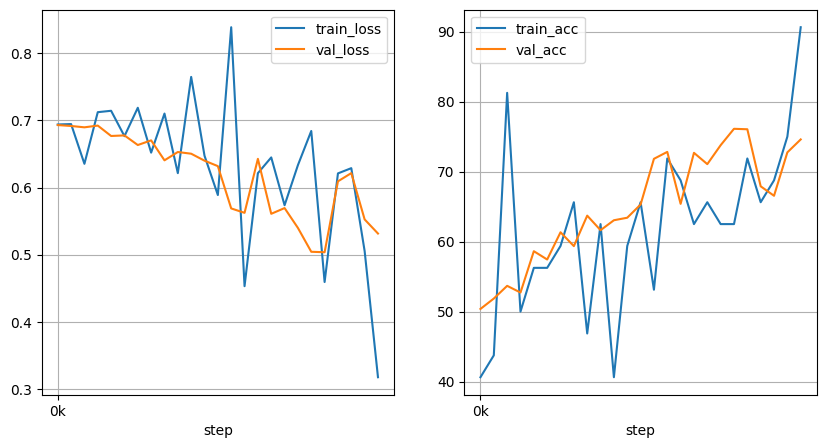

In [57]:
# 绘制学习曲线
plot_learning_curves(record_dict,sample_step=100)


In [58]:


# 在测试集上评估最终模型
test_acc, test_loss = evaluate_two_classification_model(model, val_dataloader, device, criterion)
print(f"测试集准确率: {test_acc:.2f}%, 测试集损失: {test_loss:.4f}")

测试集准确率: 74.60%, 测试集损失: 0.5315
